In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
from allison.nn import Linear, RMSprop,MSELoss,Tensor,Adam,no_grad
from allison.metrics import r2_score

In [65]:
x1 = np.linspace(1, 20*np.pi, 10000)
x2 = np.linspace(1, 20*np.pi, 10000)
y = 20*np.log(x1+5) + -0.1*x2 + 3*np.random.randn(10000)

data = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'y': y
})
data.head()

,x1,x2,y
0,1.000000,1.000000,34.621339
1,1.006184,1.006184,34.152040
2,1.012368,1.012368,34.955729
3,1.018551,1.018551,37.056821
4,1.024735,1.024735,34.887154


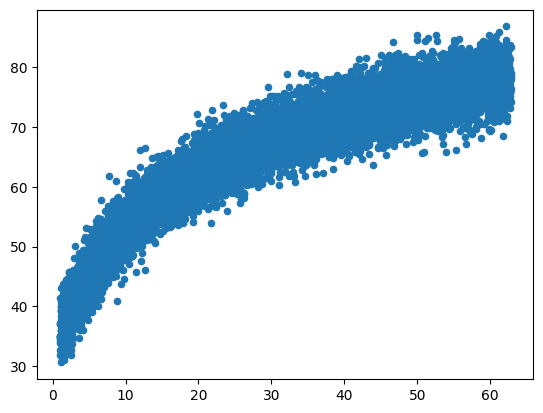

In [66]:
plt.scatter(data['x1'], data['y'], s=20)


In [67]:

class LinearRegression:
    def __init__(self,optimizer='RMSprop',lr=0.01,epsilon=1e-3):
        self._linear: Linear = None
        self._optimizer_name = optimizer
        self._optimizer = None
        self._loss = MSELoss()
        self._features_names = None
        self.lr = lr
        self.epsilon = epsilon


    def __str__(self):

        return f"LinearRegression()"
    
    def __repr__(self):
        return self.__str__()

    def _to_tensor(self, X):

        if isinstance(X, Tensor):
            return X

        if isinstance(X, (pd.DataFrame,pd.Series, np.ndarray, list)):

            if isinstance(X, pd.DataFrame):
                self._features_names = list(X.columns)
                X = X.to_numpy()
            elif isinstance(X, pd.Series):
                self._features_names = X.name
                X = X.to_numpy().reshape(-1, 1)
            elif isinstance(X, np.ndarray):
                if X.ndim > 1:
                    self._features_names = [f"F{i}" for i in range(X.shape[1])]
                else:
                    self._features_names = ["F0"]
                    X = X.reshape(-1, 1)
            elif isinstance(X, list):
                X = np.array(X)
                if X.ndim > 1:
                    self._features_names = [f"F{i}" for i in range(X.shape[1])]
                else:
                    self._features_names = ["F0"]
                    X = X.reshape(-1, 1)
            else:
                raise TypeError("La entrada debe ser un ndarray de NumPy o un DataFrame de Pandas o una lista.")
            
            return Tensor(X)

    def fit(self, X, Y,iters=10000,verbose=False):
        
        X = self._to_tensor(X)
        Y = self._to_tensor(Y)

        self._linear = Linear(X.shape[1], 1)
        
        if self._optimizer_name == 'Adam':
            self._optimizer = Adam(self._linear.parameters(), lr=self.lr)
        elif self._optimizer_name == 'RMSprop':
            self._optimizer = RMSprop(self._linear.parameters(), lr=self.lr)


        prev_loss = np.inf

        for itr in range(iters + 1):
            self._optimizer.zero_grad()
            y_pred = self._linear(X)
            loss = self._loss(y_pred, Y)
            loss.backward()
            self._optimizer.step()

            if itr % 100 == 0:
                if (prev_loss - loss.data) < self.epsilon:
                    break
                if verbose:
                    print(f"Epoch: {itr}, Loss: {loss.data}")
            prev_loss = loss.data
                
                

    def predict(self, X):
        
        X = self._to_tensor(X)
        with no_grad():
            return self._linear(X).data.flatten()
    
    def score(self, X, Y):
        return r2_score(Y, self.predict(X))

    @property
    def features_names(self):
        return self._features_names
    
    @property
    def coef_(self):
        if self._linear.W.data.shape[0] > 1:
            return self._linear.W.data.flatten()
        else:
            return self._linear.W.data[0][0]

    @property
    def intercept_(self):
        if self._linear.b.data.shape[0] > 1:
            return self._linear.b.data.flatten()
        else:
            return self._linear.b.data[0][0]

In [68]:
X = data[['x1', 'x2']]
Y = data['y']

In [69]:
X.ndim

2

In [70]:
model = LinearRegression(optimizer='RMSprop', lr=0.01, epsilon=1e-3)
model.fit(X, Y)
model.score(X, Y)

np.float64(0.8262762699107135)